In [2]:
!unzip 3d_mnist.zip

Archive:  3d_mnist.zip
  inflating: full_dataset_vectors.h5  
  inflating: plot3D.py               
  inflating: test_point_clouds.h5    
  inflating: train_point_clouds.h5   
  inflating: voxelgrid.py            


### Real Time coloring dataset (i hope all the dimensions and in the right place)

In [26]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from tqdm import tqdm

In [9]:
from dataset import MNIST3DNumberDataset

dataset_2 = MNIST3DNumberDataset(number=2, path='full_dataset_vectors.h5')
dataset_4 = MNIST3DNumberDataset(number=4, path='full_dataset_vectors.h5')

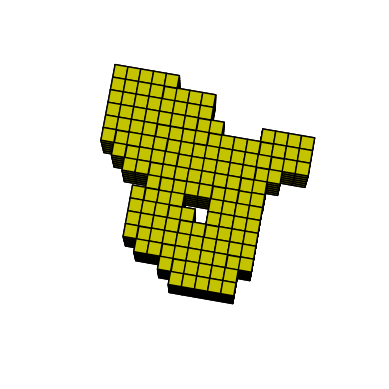

In [10]:
from utils import plot3d_static

sample = dataset_2[0]
plot3d_static(sample.numpy())

In [17]:
batch_size = 64
train_dataloader_2 = DataLoader(dataset_2, batch_size=batch_size, shuffle=True)
train_dataloader_4 = DataLoader(dataset_4, batch_size=batch_size, shuffle=True)
sample_x_batch = next(iter(train_dataloader_2))
sample_y_batch = next(iter(train_dataloader_4))
print('Sample batch dimensions: ', sample_x_batch.shape)

Sample batch dimensions:  torch.Size([64, 3, 16, 16, 16])


### Models

In [12]:
from models import ResNet_D, UNet


In [14]:
T_net = UNet(3, 3) # strong case
f_net = ResNet_D(16, nc=3)


In [18]:
T_x = T_net(sample_x_batch)

f_y = f_net(sample_y_batch)
print('Y = T(X) shape: ', T_x.shape, 'Potential of Y shape: ', f_y.shape)

Y = T(X) shape:  torch.Size([64, 3, 16, 16, 16]) Potential of Y shape:  torch.Size([64, 1])


### Train loop

In [35]:
iter_3dmnist_2, iter_3dmnist_4 = iter(train_dataloader_2), iter(train_dataloader_4)

def sample_mnist_2():
    global iter_3dmnist_2, train_dataloader_2
    try:
        return next(iter_3dmnist_2)
    except StopIteration:
        iter_3dmnist_2 = iter(train_dataloader_2)
        return next(iter_3dmnist_2)

def sample_mnist_4():
    global iter_3dmnist_4, train_dataloader_4
    try:
        return next(iter_3dmnist_4)
    except StopIteration:
        iter_3dmnist_4 = iter(train_dataloader_4)
        return next(iter_3dmnist_4)


In [36]:
sample_mnist_2().shape

torch.Size([64, 3, 16, 16, 16])

In [40]:

def sq_cost (X, Y):
    return (X-Y).square().flatten(start_dim=1).mean(dim=1)

COST = sq_cost

print('Cost(X, Y) shape', COST(sample_x_batch, T_x).shape)

T_ITERS = 5
MAX_STEPS = 10000 + 1

T = UNet(3, 3) # strong case
f = ResNet_D(16, nc=3)

T_opt = torch.optim.Adam(T.parameters(), lr=1e-4, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)


Cost(X, Y) shape torch.Size([64])


In [ ]:
DEVICE = 'cpu'

for step in tqdm(range(MAX_STEPS)):
    # T optimization
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        X = sample_mnist_2()
        X = torch.tensor(X, device=DEVICE)
        print(X.shape)
        print(T(X).shape)
        T_loss = COST(X, T(X)).mean() - f(T(X)).mean()
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    # f optimization
    T.eval(); f.train(True)
    X, Y = sample_mnist_2(), sample_mnist_4()
    X = torch.tensor(X, device=DEVICE)
    Y = torch.tensor(Y, device=DEVICE)
    f_loss = f(T(X)).mean() - f(Y).mean()
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()
    print('T_loss: ', T_loss, 'f_loss: ', f_loss)
    if step % 200 == 0:
#         clear_output(wait=True)
        print("Step", step)

        # TODO: The code for plotting the results
        
        
        

  0%|                                                                                                                    | 0/10001 [00:00<?, ?it/s]/tmp/ipykernel_75302/3701523764.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=DEVICE)


torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])


/tmp/ipykernel_75302/3701523764.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, device=DEVICE)
/tmp/ipykernel_75302/3701523764.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, device=DEVICE)
  0%|                                                                                                        | 1/10001 [01:18<218:48:07, 78.77s/it]

T_loss:  tensor(0.2567, grad_fn=<SubBackward0>) f_loss:  tensor(-0.0070, grad_fn=<SubBackward0>)
Step 0
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([16, 3, 16, 16, 16])
torch.Size([16, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])


  0%|                                                                                                        | 2/10001 [02:30<207:22:38, 74.66s/it]

T_loss:  tensor(0.1571, grad_fn=<SubBackward0>) f_loss:  tensor(-0.0202, grad_fn=<SubBackward0>)
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])


  0%|                                                                                                        | 3/10001 [03:51<215:13:59, 77.50s/it]

T_loss:  tensor(0.0975, grad_fn=<SubBackward0>) f_loss:  tensor(-0.0209, grad_fn=<SubBackward0>)
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])


  0%|                                                                                                        | 4/10001 [05:12<218:51:57, 78.82s/it]

T_loss:  tensor(0.0685, grad_fn=<SubBackward0>) f_loss:  tensor(-0.0206, grad_fn=<SubBackward0>)
torch.Size([16, 3, 16, 16, 16])
torch.Size([16, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])


  0%|                                                                                                        | 5/10001 [06:26<214:30:58, 77.26s/it]

T_loss:  tensor(0.0364, grad_fn=<SubBackward0>) f_loss:  tensor(-0.0211, grad_fn=<SubBackward0>)
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
torch.Size([64, 3, 16, 16, 16])
